In [1]:
import cv2
import matplotlib.pyplot as plt
import dlib
import numpy as np

In [2]:
my_image_path = "./images/image05.jpg"

# 이미지 불러오기
img_bgr = cv2.imread(my_image_path)

# 출력용 이미지 따로 보관
img_show = cv2.imread(my_image_path)

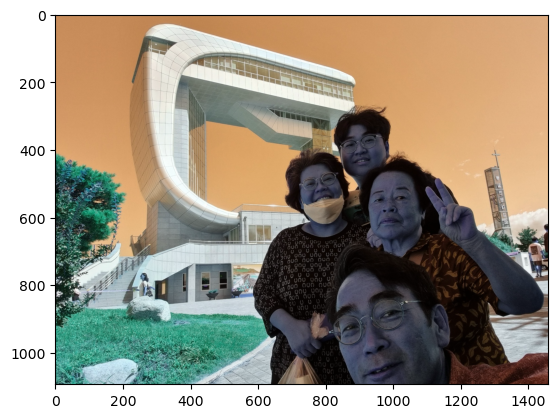

In [3]:
plt.imshow(img_show)
plt.show()

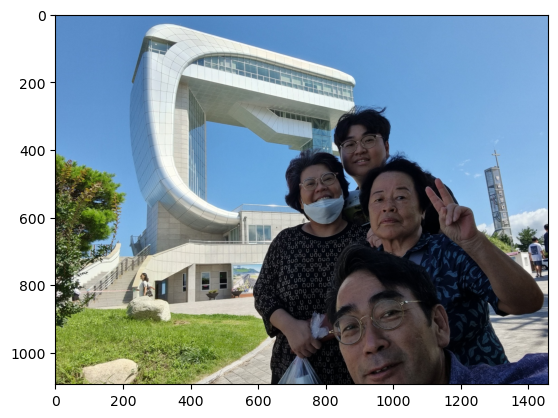

In [4]:
# RGB 순으로 변경
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [5]:
# detector 객체 선언
# 기본 얼굴 detector
detector_hog = dlib.get_frontal_face_detector()

In [6]:
# RGB순으로 변경하여 변수에 저장
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# 해당 이미지 변수를 detector의 매개변수로 전달하여 얼굴 detect하기
dlib_rects = detector_hog(img_rgb, 1)

print(dlib_rects)

rectangles[[(841, 340) (970, 469)], [(927, 512) (1056, 641)], [(812, 812) (1133, 1133)], [(726, 454) (855, 583)]]


- 총 4개의 얼굴이 감지됨
- [(Left, Top), (Right, Bottom)] 꼴로 감지

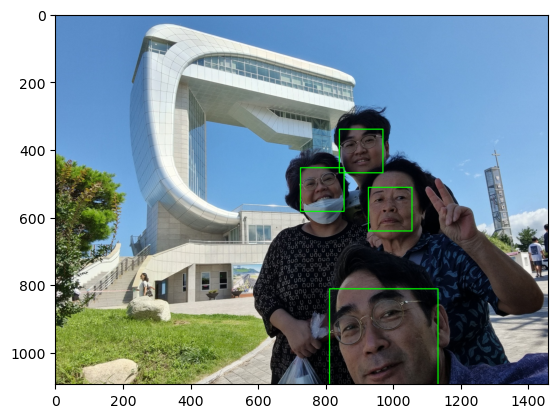

In [7]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    # (0, 255, 0) -> (B, G, R) 사각형의 색상
    # 2 -> 선 두께
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0),
                  2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- bottom up : box 생성 후 안에서 point 찾기
- top down : point 먼저 찾고 clustering을 통해 box 생성

In [8]:
model_path = "./models/shape_predictor_68_face_landmarks.data"

# face_landmarks model 불러오기
landmark_predictor = dlib.shape_predictor(model_path)
# 해당 모델의 파라미터로 RGB이미지, dlib.rectangle 입력 가능
# dlib.full_object_detection 반환
# dlib.rectangle : 내부를 예측하는 박스
# dlib.full_object_detection : 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄 

In [9]:
# landmark 위치를 저장할 list 생성
list_landmarks = []

# 얼굴 영역 박스마다 face landmark 탐색
# face landmark 좌표 저장
for dlib_rect in dlib_rects:
    # 해당 rectangle에 대하여 모든 landmark의 위치정보를 points 변수에 저장
    points = landmark_predictor(img_rgb, dlib_rect)

    # 각각의 landmark 위치 정보를 (x, y) 형태로 변환하여 list_points 리스트로 저장
    list_points = list(map(lambda p : (p.x, p.y), points.parts()))

    # list_landmarks에 해당 rectangle에 대한 landmark정보를 담은 list 저장
    list_landmarks.append(list_points)

# rectangle 개수 출력
n = len(list_landmarks)
print(n)

# rectangle 당 landmark 개수 출력
print(len(list_landmarks[0]))

4
68


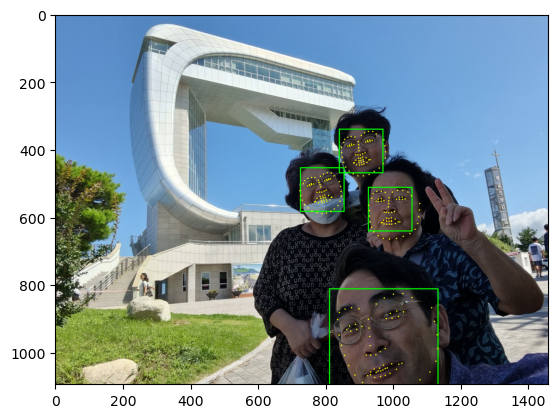

In [10]:
for rec_landmark in list_landmarks:
    for point in rec_landmark:
        # cv2.circle : OpenCV의 원을 그리는 함수
        # 위에서 사용했던 cv2.rectangle()과 유사
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [11]:
x = []
y = []
w = []
h = []
for i, (dlib_rect, landmark) in enumerate(zip(dlib_rects, list_landmarks)):
    print(landmark[33])
    x.append(landmark[33][0])
    y.append(landmark[33][1])
    w.append(dlib_rect.width())
    h.append(dlib_rect.height())
    print (f'(x,y) : ({x[i]},{y[i]})')
    print (f'(w,h) : ({w[i]},{h[i]})')

(903, 416)
(x,y) : (903,416)
(w,h) : (130,130)
(987, 587)
(x,y) : (987,587)
(w,h) : (130,130)
(949, 1007)
(x,y) : (949,1007)
(w,h) : (322,322)
(789, 526)
(x,y) : (789,526)
(w,h) : (130,130)


In [12]:
# 고양이 수염 이미지 경로
sticker_path = "./images/cat-whiskers.png"

img_sticker = []
for i in range(n):

    # 스티커 이미지를 불러오기 // cv2.imread(이미지 경로) → image객체 행렬을 반환
    img_sticker.append(cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED))

    # 스티커 이미지 조정 
    # w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수 // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
    img_sticker[i] = cv2.resize(img_sticker[i], (w[i], h[i]))

    # 사이즈를 조정한 고양이 수염 이미지 shape 확인
    print (img_sticker[i].shape) 

(130, 130, 4)
(130, 130, 4)
(322, 322, 4)
(130, 130, 4)


In [13]:
# 수염 이미지의 시작 지점, 끝 지점 찾기
refined_x = []
refined_y = []

for i in range(n):
    sticker_shape_x = img_sticker[i].shape[0]
    sticker_shape_y = img_sticker[i].shape[1]

    left   = x[i] - sticker_shape_x // 2
    right  = x[i] + sticker_shape_x // 2
    top    = y[i] - sticker_shape_y // 2
    bottom = y[i] + sticker_shape_y // 2

    refined_x.append([left, right])   # [왼쪽, 오른쪽]
    refined_y.append([top, bottom])   # [위, 아래]

    # 왼쪽으로 스티커가 넘어간 경우
    if left < 0:
        # 왼쪽 잘라내고, 0에서 시작
        img_sticker[i] = img_sticker[i][:, -left:]
        refined_x[i][0] = 0

    # 오른쪽으로 넘어간 경우
    if right > img_show[i].shape[0]:
        # 오른쪽 잘라내고, 최대 너비까지에서 끝
        img_sticker[i] = img_sticker[i][:, :img_show[i].shape[0]] 
        refined_x[i][1] = img_show[i].shape[0]

    # 얼굴 이미지의 가운데에 들어가기에, 위 아래 scaling은 필요 없을 듯
    
    print (f'(x,y) : ({refined_x[i]},{refined_y[i]})')

(x,y) : ([838, 968],[351, 481])
(x,y) : ([922, 1052],[522, 652])
(x,y) : ([788, 1110],[846, 1168])
(x,y) : ([724, 854],[461, 591])


In [14]:
sticker_area = []

for i in range(n):
    sticker_area.append(img_show[refined_y[i][0]:refined_y[i][1], 
                                 refined_x[i][0]:refined_x[i][1]])
    
    # 잘라낸 sticker크기에 맞게 resize 진행
    h, w = sticker_area[i].shape[:2]
    img_sticker[i] = cv2.resize(img_sticker[i], (w, h), interpolation=cv2.INTER_AREA)

    # 채널 수 다르면 맞춰주기 (BGR → BGRA)
    # BGRA -> BGR + A로 분리하고 A로 나중에 sticker의 투명도 조절
    if img_sticker[i].shape[2] == 3:
        img_sticker[i] = cv2.cvtColor(img_sticker[i], cv2.COLOR_BGR2BGRA)

    # img_show에 대해서 위치 찍어주기 -> np.where 진행
    img_show[refined_y[i][0]:refined_y[i][1],
             refined_x[i][0]:refined_x[i][1]] = np.where(
                 img_sticker[i][:, :, 3:] == 0, 
                 sticker_area[i], 
                 img_sticker[i][:, :, :3]
                 ).astype(np.uint8)

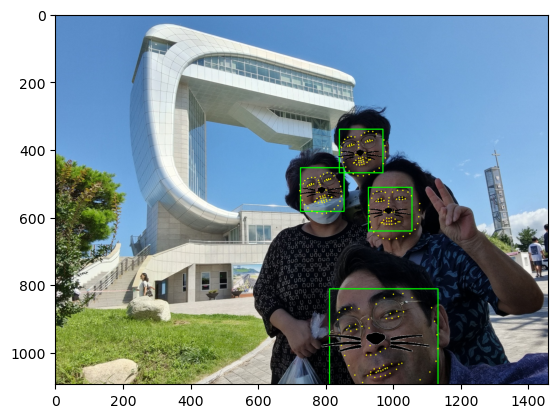

In [15]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

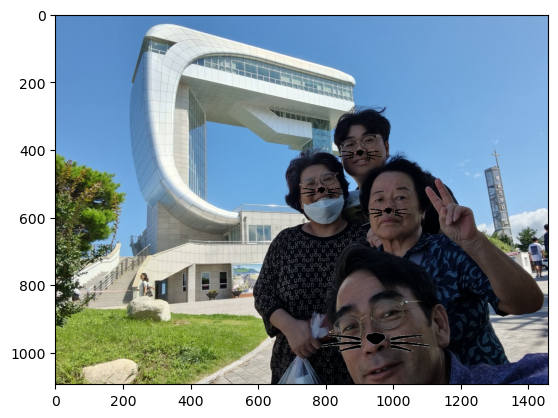

In [16]:
sticker_area = []

for i in range(n):

    sticker_area.append(img_bgr[refined_y[i][0]:refined_y[i][1], 
                                 refined_x[i][0]:refined_x[i][1]])

    # img_show에 대해서 위치 찍어주기 -> np.where 진행
    img_bgr[refined_y[i][0]:refined_y[i][1],
             refined_x[i][0]:refined_x[i][1]] = np.where(
                 img_sticker[i][:, :, 3:] == 0, 
                 sticker_area[i], 
                 img_sticker[i][:, :, :3]
                 ).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()